## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [1]:
import os
import json
import phik
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from phik.report import plot_correlation_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

Загрузка данных происходит ниже. Если она не срабатывает, самостоятельно скачайте файл `hw_final_open_data.npy` и положите его в ту же директорию, что и ноутбук.

In [ ]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_data.npy

In [2]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

#### Проверка корреляции между признаками

Объединение признаков в один датафрейм

In [3]:
dataframe = pd.DataFrame(data=data,
                         index=target,
                         columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'])

Построение матрицы корреляций

interval columns not set, guessing: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']


/tmp/ipykernel_15737/1512193725.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


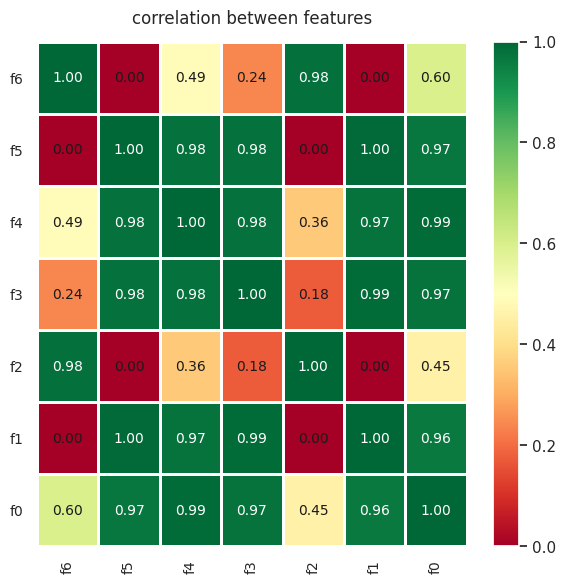

In [4]:
phik_overview = dataframe.phik_matrix()
sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, 
                        figsize=(6, 6))

plt.title('correlation between features', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

Вывод:
- наблюдается сильная корреляция между f4, f3, f1, f0 и f5, f2 и f6
- можно попробовать удалить f5, f4, f3, f1 и f6

#### Разбивка на `train` и `val` опциональна и сделана для вашего удобства.

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((560, 7), (560,), (240, 7), (240,))

### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

Подбор гиперпараметров Random Forest

#### Линейная модель без подбора гиперпараметров

In [6]:
rdg = Ridge()
rdg.fit(train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(np.round(rdg.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(rdg.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)
# baseline: 1.36 train mse =	 0.18150 validation mse = 0.27500

train mse =	 0.18214
validation mse = 0.24167


#### Случайный лес без подбора гиперпараметров

In [ ]:
rf = RandomForestRegressor()
rf.fit(train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(np.round(rf.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(rf.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)
# baseline: 0.73 train mse =	 0.10581 validation mse = 0.32083

#### Случайный лес с подбором гиперпараметров

In [ ]:
params_rfr = (
    {'n_estimators': [50, 100, 150],
     'max_depth':[2, 5, 10],
     'random_state':[42],
     'n_jobs': [-1]}
    )

rf = RandomForestRegressor()
rf_gs = GridSearchCV(rf, params_rfr, scoring='neg_mean_squared_error')
rf_gs.fit(train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(np.round(rf_gs.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(rf_gs.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)
print(max([np.round((1 - (mean_squared_error(np.round(rf_gs.predict(valid_x)), np.round(valid_y)))) * 1.5, 2), 0]))
print(f"параметры лучшей модели: {rf_gs.best_params_}")
feature_importances_rf = rf_gs.best_estimator_.feature_importances_
for feature_name, importance in zip(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'], feature_importances_rf):
    print(f'{feature_name}: {importance}')

# результат_1 30.11.23 - 0.95 (train mse = 0.16293, validation mse = 0.23333, 1.15) без f2, f6
# результат_2 30.11.23 - 0.91 (train mse = 0.15638, validation mse = 0.26250, 1.11) без f2, f3, f6

#### Бустинг с подбором гиперпараметров

In [ ]:
params_gbr = (
    {'learning_rate': [0.1, 0.15, 0.2, 0.25],
     'max_depth':[2, 3, 4],
     'n_estimators': [20, 25, 30, 35, 40],
     'random_state':[42]}
    )
# List of parameters: ['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 
#                      'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 
#                      'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 
#                      'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'].
gbr = GradientBoostingRegressor()

gbr_gs = GridSearchCV(gbr, params_gbr, n_jobs=-1, scoring='neg_mean_squared_error')
gbr_gs.fit(train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(np.round(gbr_gs.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(gbr_gs.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)

print(max([np.round((1 - (mean_squared_error(np.round(gbr_gs.predict(valid_x)), np.round(valid_y)))) * 1.5, 2), 0]))
print(f"параметры лучшей модели: {gbr_gs.best_params_}")
feature_importances = gbr_gs.best_estimator_.feature_importances_
for feature_name, importance in zip(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'], feature_importances):
    print(f'{feature_name}: {importance}')

# результат_1 29.11.23 - 0.61 (train mse = 0.165, validation mse = 0.23750)
# результат_2 29.11.23 - 0.79 (train mse = 0.15643, validation mse = 0.3)
# результат_3 29.11.23 - 1.02 (train mse = 0.15099, validation mse = 0.26667) без f2, f3, f6
# результат_4 29.11.23 - 0.89 (train mse = 0.15055, validation mse = 0.27917) без f2, f6
# результат_5 29.11.23 - 0.81 (train mse = 0.16388, validation mse = 0.25) без f2, f3, f4 f6
# результат_6 30.11.23 - 0.91 (train mse = 0.15493, validation mse = 0.30833, 1.04) без f1, f3, f4, f5, f6, последнее обучение на полных данных
# результат_7 30.11.23 - 0.84 (train mse = 0.15752, validation mse = 0.25833) без f2, f3, f6, последнее обучение на полных данных

Удаление наименее значимых признаков

In [ ]:
# менее значимые признаки
least_important_indices = [2, 3, 6]
# Удаляем наименее значимые признаки
train_x = np.delete(train_x, least_important_indices, axis=1)
valid_x = np.delete(valid_x, least_important_indices, axis=1)

Обучение модели на полной выборке

In [7]:
# gbr = GradientBoostingRegressor(learning_rate = 0.15, max_depth = 3, n_estimators = 30, random_state = 42)
# gbr.fit(np.delete(data, least_important_indices, axis=1), target)

rdg.fit(data, target)

Ridge()

#### Выводы:
- проведено исследование признаков на корреляцию
- обучены неколько моделей:
    - линейная модель без подбора гиперпараметров и удаления признаков
    - случайный лес без бодбора гиперпараметров и удаления признаков
    - случайный лес с grid search, cross-validation и удалением малозначимых и скоррелированных признаков
    - градиентный бустинг с grid search, cross-validation и удалением малозначимых и скоррелированных признаков
- наилучший результат показала линейная модель без подбора гиперпараметров и удаления скоррелированных признаков
- вероятно, признаки были синтетически сгенерированы и зашумлены

##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [ ]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

In [8]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [9]:
def get_predictions(model, eval_data, step=10):
    # eval_data = np.delete(eval_data, least_important_indices, axis=1) # добавлено
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [10]:
predicted_values = np.round(get_predictions(model=rdg, eval_data=closed_data), 2) # gbr

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

In [ ]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.json`')
# __________end of block__________

### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [11]:
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    # new_feature_matrix[:, -1] = feature_matrix[:, 0] * feature_matrix[:, 1] # 2: произведение первого и второго исходных признаков
    # new_feature_matrix[:, -3] = np.exp(feature_matrix[:, 2])  # Преобразование третьего признака с помощью экспоненты
    new_feature_matrix[:, -2] = np.power(feature_matrix[:, 3], 3)  # Преобразование четвертого признака с помощью возведения в куб
    # new_feature_matrix[:, -1] = feature_matrix[:, 0] + feature_matrix[:, 1]  # Преобразование пятого признака с помощью сложения первого и второго признаков
    new_feature_matrix[:, -4] = np.cumprod(feature_matrix[:, 1])
    # new_feature_matrix[:, -5] = np.cumprod(feature_matrix[:, 6])
    new_feature_matrix[:, -1] = np.gradient(feature_matrix[:, 0] * feature_matrix[:, 1] * feature_matrix[:, 2] 
                                            * feature_matrix[:, 3] * feature_matrix[:, 4] * feature_matrix[:, 5])
    
    return new_feature_matrix

In [12]:
transformed_train_x = my_transformation(train_x)
train_x.shape, transformed_train_x.shape

((560, 7), (560, 8))

In [13]:
lr = Ridge()
lr.fit(transformed_train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(lr.predict(transformed_train_x), train_y):.5f}',
    f'validation mse = {mean_squared_error(lr.predict(my_transformation(valid_x)), valid_y):.5f}',
    sep='\n'
)
print(max([0, np.round((0.5 - mean_squared_error(lr.predict(my_transformation(valid_x)), valid_y)) * 3 , 2)]))
# базовая модель: train mse = 0.08772, validation mse = 0.09759 1.21
# посылка_1 29.11.23: 1.23, train mse =	 0.08829 validation mse = 0.09846
# посылка_2 29.11.23: 1.2, train mse =	 0.09160 validation mse = 0.10219
# посылка_3 29.11.23: 1.23, train mse =	 0.08766 validation mse = 0.09751
# посылка_4 29.11.23: 1.23, train mse =	 0.08758 validation mse = 0.09744

train mse =	 0.08903
validation mse = 0.09383
1.22


Обращаем ваше внимание, что параметры линейной модели будут округляться до __четырех знаков после запятой__. Это не должно сильно повлиять на качество предсказаний:

In [14]:
original_predictions = lr.predict(transformed_train_x)
rounded_predictions = transformed_train_x.dot(np.round(lr.coef_, 4)) + np.round(lr.intercept_, 4)


assert np.allclose(original_predictions, rounded_predictions, atol=1e-3)

Параметры вашей модели:

In [15]:
w_list = list(np.round(lr.coef_, 4))
print(f'w = {list(np.round(lr.coef_, 4))}\nb = {np.round(lr.intercept_, 4)}')

w = [0.011, 0.4804, 0.0, 0.5748, -0.0075, 1.4377, 0.1454, -0.1117]
b = 1.4075


Напоминаем, ваша модель не должна использовать более 15 параметров (14 весов плюс свободный член).

In [16]:
assert len(w_list) + 1 <= 15

##### Сдача второй части соревнования
Для сдачи вам достаточно отправить функцию `my_transformation` и параметры вашей модели в контест в задачу №2. Пример посылки доступен ниже

In [17]:
# __________example_submission_start__________
import numpy as np
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    new_feature_matrix[:, -2] = np.power(feature_matrix[:, 3], 3)
    new_feature_matrix[:, -4] = np.cumprod(feature_matrix[:, 1])
    new_feature_matrix[:, -1] = np.gradient(feature_matrix[:, 0] * feature_matrix[:, 1] * feature_matrix[:, 2] * feature_matrix[:, 3] * feature_matrix[:, 4] * feature_matrix[:, 5])
    return new_feature_matrix

w_submission = [0.0109, 0.4755, 0.0, 0.5778, -0.0335, 1.4335, 0.0842, -0.151]
b_submission = 1.4187
# __________example_submission_end__________

На этом задание завершено. Поздравляем!